In [ ]:
#data available at https://www.kaggle.com/c/dogs-vs-cats/data

In [1]:
import os
os.environ['KAGGLE_USERNAME'] = "....." # username from the json file find in kaggle personal acct
os.environ['KAGGLE_KEY'] = "....." # Provide your key from the json file, find in kaggle personal acct
!kaggle competitions download -c dogs-vs-cats # api copied from kaggle

sampleSubmission.csv: Skipping, found more recently modified local copy (use --force to force download)
train.zip: Skipping, found more recently modified local copy (use --force to force download)
test1.zip: Skipping, found more recently modified local copy (use --force to force download)


In [2]:
# load data and extract the contents
from zipfile import ZipFile

file_name = "/content/train.zip"    ##extract my training data

with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('done')

done


In [3]:
import pandas as pd
import numpy as np
import os


In [4]:
####create dataframe template to use in datagenerator
categories=[]   


filenames=os.listdir('/content/train') 
for img in filenames:
    if img.startswith('dog'):
        categories.append('dog')
        
    else:
        categories.append('cat') 
        
        
df=pd.DataFrame({'data':filenames,
                 'category':categories})
     
df.head()

,data,category
0,dog.8866.jpg,dog
1,cat.2501.jpg,cat
2,dog.12445.jpg,dog
3,cat.2993.jpg,cat
4,dog.10156.jpg,dog


In [5]:

from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df,test_size = 1000, stratify=df['category'])

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#We need to normalize image
##we can specify validation split in the generator, instead of creating 2 new dataframe
datagen = ImageDataGenerator(rescale=1./255., validation_split=0.25)

In [7]:
train=datagen.flow_from_dataframe(train_df,
                                  directory='/content/train',
                                  x_col='data',  ###column with name of image
                                  y_col='category', ##column with label in string
                                  subset='training',  ##important for the model
                                  class_mode='categorical',
                                  shuffle=True,
                                  target_size=(224, 224), ##resize all image to the specified size
                                  batch_size=32 ##run the image 30 at once
                                 )


val=datagen.flow_from_dataframe(train_df,
                                directory='/content/train',
                                x_col='data',  ###column with name of image
                                y_col='category', ##column with label in string
                                subset='validation',
                                class_mode='categorical',
                                shuffle=True,
                                target_size=(224, 224), ##resize all image to the specified size
                                batch_size=32 ##run the image 30 at once
                                 )

###load test data
test_datagen=ImageDataGenerator(rescale=1./255.)
test=test_datagen.flow_from_dataframe(test_df,
                                  directory='/content/train',
                                  x_col='data',  ###column with name of image
                                  y_col=None, ##column with label in string
                                  shuffle=False,
                                  class_mode=None, ##we only need the x_colume for prediction
                                  target_size=(224, 224), ##resize all image to the specified size
                                  batch_size=32 ##run the image 30 at once
                                 )

Found 18000 validated image filenames belonging to 2 classes.
Found 6000 validated image filenames belonging to 2 classes.
Found 1000 validated image filenames.


In [8]:
from tensorflow.keras.models import Sequential   #to create sequence of layer action
from tensorflow.keras.layers import Conv2D, Dense, MaxPooling2D, Activation, Flatten, Dropout, BatchNormalization
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.metrics import categorical_accuracy

In [9]:
##initialize model and add layers of your NN
K.clear_session()   #always start your NN session with it
model= Sequential([
    Conv2D(filters = 64, kernel_size = (3,3), strides = (1,1), padding = 'same', activation = 'relu' ,input_shape = (224,224,3)),
    MaxPooling2D(pool_size = (2,2),strides=(2,2),padding = 'same'), 
    
    Conv2D(filters = 128, kernel_size = (3,3), strides = (1,1), padding = 'same', activation = 'relu'),
    Conv2D(filters = 128, kernel_size = (3,3), strides = (1,1), padding = 'same', activation = 'relu'),
    MaxPooling2D(pool_size = (2,2),strides=(2,2),padding = 'same'), 
    
        
    Conv2D(filters = 256, kernel_size = (3,3), strides = (1,1), padding = 'same', activation = 'relu'),
    Conv2D(filters = 256, kernel_size = (3,3), strides = (1,1), padding = 'same', activation = 'relu'),
    MaxPooling2D(pool_size = (2,2),strides=(2,2),padding = 'same'), 
    
    Conv2D(filters = 512, kernel_size = (3,3), strides = (1,1), padding = 'same', activation = 'relu'),
    Conv2D(filters = 512, kernel_size = (3,3), strides = (1,1), padding = 'same', activation = 'relu'),
    MaxPooling2D(pool_size = (2,2),strides=(2,2),padding = 'same'), 
    
    ###steps involve in ordinary ANN
    
    
    Flatten(),  ##convert shape of array to 2 dimension, the number of samples stay the same and
               #the other other dimensions i.e pixel sizes (a*b) are mutiplied by the num of channels
    
    Dense(5000,activation='relu'),
    Dropout(0.2),  ##helps to prevent overfitting in NN
    Dense(5000,activation='relu'),
    Dropout(0.4),
    Dense(2, activation = 'sigmoid')   #bctwo classes
    
])

In [10]:
#check model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 64)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 128)     73856     
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 112, 128)     147584    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 128)      0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 56, 56, 256)       2

In [11]:
model.compile(optimizer=Adam(learning_rate=0.001),
              loss=binary_crossentropy,
              metrics=[categorical_accuracy])

In [12]:
##model.fit_generator is use bcos it is datagenrator type of data
from keras.callbacks import EarlyStopping


# observe the validation loss and stop when it does not improve after 10 iterations
callback = EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(
    x=train,
    epochs=30,  #20 iterations
    verbose=1,
    callbacks=callback,
    steps_per_epoch=train.n//train.batch_size,  ##based on length of train
    validation_data=val,
    validation_steps=val.n//val.batch_size  ##num of steps for vaidatn iteration
)  

Epoch 1/30
562/562 [==============================] - 413s 713ms/step - loss: 0.7521 - categorical_accuracy: 0.4974 - val_loss: 0.6931 - val_categorical_accuracy: 0.5060
Epoch 2/30
562/562 [==============================] - 394s 701ms/step - loss: 0.6932 - categorical_accuracy: 0.4995 - val_loss: 0.6931 - val_categorical_accuracy: 0.5064
Epoch 3/30
562/562 [==============================] - 394s 700ms/step - loss: 0.6933 - categorical_accuracy: 0.4965 - val_loss: 0.6932 - val_categorical_accuracy: 0.4938
Epoch 4/30
562/562 [==============================] - 394s 700ms/step - loss: 0.6932 - categorical_accuracy: 0.4986 - val_loss: 0.6934 - val_categorical_accuracy: 0.4935
Epoch 5/30
562/562 [==============================] - 394s 700ms/step - loss: 0.6932 - categorical_accuracy: 0.5043 - val_loss: 0.6934 - val_categorical_accuracy: 0.4940
Epoch 6/30
562/562 [==============================] - 393s 699ms/step - loss: 0.6932 - categorical_accuracy: 0.5001 - val_loss: 0.6932 - val_categoric

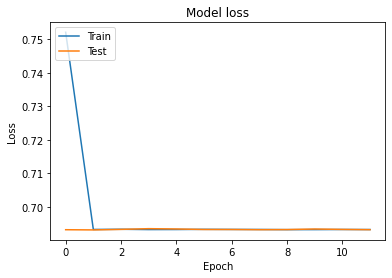

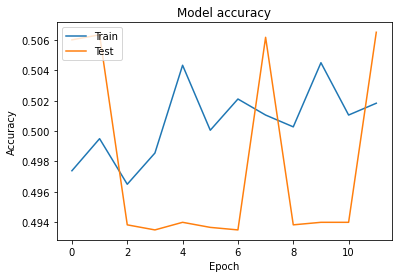

In [13]:
import matplotlib.pyplot as plt
#Loss
plt.plot(history.history['loss']) 
plt.plot(history.history['val_loss']) 
plt.title('Model loss') 
plt.ylabel('Loss') 
plt.xlabel('Epoch') 
plt.legend(['Train', 'Test'], loc='upper left') 
plt.show()

#Accuracy
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
##The custom model did not perform well 
##Next_step_ try_transfer_learning_
##See week Project